MLP

Based on "A Neural Probabilistic Language Model" 
https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

In [203]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
%matplotlib inline
words = open('names.txt', 'r').read().splitlines()
g = torch.Generator().manual_seed(2147483647)

Split the dataset

In [204]:
import random
random.shuffle(words)

# Split the original list into train, dev, and test parts
def split_words(words):
    n = len(words)
    size_1 = int(n * 0.8)
    size_2 = int(n * 0.1)
    return words[:size_1], words[size_1:size_1+size_2], words[size_1+size_2:]

# train_words, dev_words, test_words = split_words(words)
train_words, dev_words, test_words = split_words(words) 

In [205]:
# Constants and hyper params

# Number of characters to use for predicting the next character
block_size = 3
embedding_size = 10 # size of the embedding vector ("C" in the paper)
hidden_layer_size = 100
vocab_size = 27

batch_size = 1000  # training

In [206]:
# build vocab
all_chars = sorted(list(set(''.join(words) + ".")))

# build stoi and itos for 'chars'
def build_stoi_itos(chars):
    stoi = {}
    itos = {}
    for i, c in enumerate(chars):
        stoi[c] = i
        itos[i] = c
    return stoi, itos

stoi, itos = build_stoi_itos(all_chars)


Define functions to build the labels

In [207]:
def add_padding(word, n):
  return '.'*n + word + '.'*n

def sliding_window(lst, n):
    """
    Returns a list of size N groupings from the given list using sliding window
    Example: sliding_window("helloworld", 3) -> ["hel", "ell", "llo", "low", "owo", "wor", "orl", "rld"]
    """
    return [lst[i:i+n] for i in range(len(lst)-n+1)]
    
def padded_sliding_window(input, n):
  padded = add_padding(input, n - 1)
  return sliding_window(padded, n)

# Example:
# get_labeled_data(["hello", "world"], 2) 
# xs -> tensor([[. .], [. h], [h e], [e l], [l l], [l o], [o .], [. w], [w o], [o r], [r l], [l d], [d .], [. .])
# ys -> tensor([h, e, l, l, o, ., w, o, r, l, d, ., ., .])
def get_labeled_data(words_list, block_size):
    xs, ys = [], []
    num_examples = 0
    for w in words_list:
        examples = padded_sliding_window(w, block_size + 1)
        for example in examples:
          xsi = []
          inputs = example[:block_size]
          for i in inputs:
            xsi.append(stoi[i])

          output = example[-1]
          ys.append(stoi[output])
          num_examples += 1
          xs.append(xsi)

    
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    return xs, ys,num_examples 


In [208]:
train_xs, train_ys, train_num_examples = get_labeled_data(train_words, block_size)
dev_xs, dev_ys, dev_num_examples = get_labeled_data(dev_words, block_size)
test_xs, test_ys, test_num_examples = get_labeled_data(test_words, block_size)

In [209]:
print("Train words num: ", len(train_words))
print("Training examples size: ", train_num_examples)


print("Dev words num: ", len(dev_words))
print("Dev examples size: ", dev_num_examples)

print("Test words num: ", len(test_words))
print("Test examples size: ", test_num_examples)


Train words num:  25626
Training examples size:  233769
Dev words num:  3203
Dev examples size:  29229
Test words num:  3204
Test examples size:  29214


In [210]:
# Embedding layer C
# Embeds a token (single character) into a lower dimentional space. In the paper they have 17k words embedded into 30 dim space
C = torch.randn((vocab_size, embedding_size), requires_grad=True, generator=g)

# Network init
W1 = torch.randn((embedding_size * block_size, hidden_layer_size), requires_grad=True, generator=g)
b1 = torch.randn((1, hidden_layer_size), requires_grad=True, generator=g)

W2 = torch.randn((hidden_layer_size, vocab_size), requires_grad=True, generator=g)
b2 = torch.randn((1, vocab_size), requires_grad=True, generator=g)

params = [C, W1, b1, W2, b2]

# print shapes of the network
print("C shape: ", C.shape)
print("W1 shape: ", W1.shape)
print("b1 shape: ", b1.shape)
print("W2 shape: ", W2.shape)
print("b2 shape: ", b2.shape)

C shape:  torch.Size([27, 10])
W1 shape:  torch.Size([30, 100])
b1 shape:  torch.Size([1, 100])
W2 shape:  torch.Size([100, 27])
b2 shape:  torch.Size([1, 27])


In [214]:
# optimization and backprop
learning_rate = 0.01
# optimizer = torch.optim.SGD([C, W1, b1, W2, b2], lr=learning_rate)

lossi = []
stepi = []
for i in range(50000):   
    # mini batch
    batch_idx = torch.randint(0, train_xs.shape[0], (batch_size,))

    emb = C[train_xs[batch_idx]].view((-1, block_size * embedding_size))

    l1 = emb @ W1 + b1
    l1_tanh = torch.tanh(l1)

    l2 = l1_tanh @ W2 + b2
    # l2_softmax = F.softmax(l2, dim=1)

    # caculate cross entropy loss
    loss = F.cross_entropy(l2, train_ys[batch_idx]) # + 1*(W1**2).mean() + 1*(W2**2).mean() # + 1*(C**2).mean()

    for param in params:
        param.grad = None
    loss.backward()

    for param in params:
        param.data += -learning_rate * param.grad
    
    lossi.append(loss.item())
    stepi.append(i)

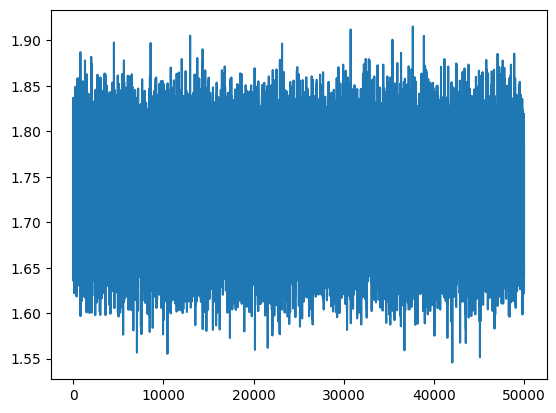

In [215]:
# plot lossi
plt.plot(stepi, lossi)

In [216]:
emb = C[train_xs].view((-1, block_size * embedding_size))

l1 = emb @ W1 + b1
l1_tanh = torch.tanh(l1)

l2 = l1_tanh @ W2 + b2
# l2_softmax = F.softmax(l2, dim=1)

# caculate cross entropy loss
loss = F.cross_entropy(l2, train_ys) # + 1*(W1**2).mean() + 1*(W2**2).mean() + 1*(C**2).mean()
loss 

tensor(1.7267, grad_fn=<NllLossBackward0>)

In [106]:
training_data_tensor = torch.tensor([1,2,3,4,5,6,7,8,9])
labels = torch.tensor([11,12,13,14,15,16,17,18,19])
dataset = TensorDataset(training_data_tensor, labels)
dataloader = DataLoader(dataset, 2, shuffle=True)

x tensor([2, 7])
y tensor([12, 17])
1
x tensor([9, 5])
y tensor([19, 15])
2
x tensor([8, 1])
y tensor([18, 11])
3
x tensor([6, 4])
y tensor([16, 14])
4
x tensor([3])
y tensor([13])
5


Exercises:
- E01: Tune the hyperparameters of the training to beat my best validation loss of 2.2
- E02: I was not careful with the intialization of the network in this video. (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?
- E03: Read the Bengio et al 2003 paper (link above), implement and try any idea from the paper. Did it work?